In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from scipy import stats 
%matplotlib inline

In [3]:
mba_salary_df = pd.read_csv('MBA Salary.csv')
mba_salary_df.head()

,S. No.,Percentage in Grade 10,Salary
0,1,62.00,270000
1,2,76.33,200000
2,3,72.00,240000
3,4,60.00,250000
4,5,61.00,180000


In [4]:
mba_salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   S. No.                  50 non-null     int64  
 1   Percentage in Grade 10  50 non-null     float64
 2   Salary                  50 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 1.3 KB


In [5]:
import statsmodels.api as sm
X = sm.add_constant(mba_salary_df['Percentage in Grade 10'])
X.head()

,const,Percentage in Grade 10
0,1.0,62.00
1,1.0,76.33
2,1.0,72.00
3,1.0,60.00
4,1.0,61.00


In [6]:
Y = mba_salary_df['Salary']

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(X,Y, train_size = 0.8, random_state = 100)

In [9]:
mba_salary_lm = sm.OLS(train_Y, train_X).fit()

In [10]:
print(mba_salary_lm.params)

const                     30587.285652
Percentage in Grade 10     3560.587383
dtype: float64


In [11]:
mba_salary_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                    OLS                   Adj. R-squared:          0.190     
Dependent Variable:       Salary                AIC:                     1008.8680 
Date:                     2025-09-12 11:30      BIC:                     1012.2458 
No. Observations:         40                    Log-Likelihood:          -502.43   
Df Model:                 1                     F-statistic:             10.16     
Df Residuals:             38                    Prob (F-statistic):      0.00287   
R-squared:                0.211                 Scale:                   5.0121e+09
-----------------------------------------------------------------------------------
                         Coef.     Std.Err.    t    P>|t|     [0.025       0.975]  
-----------------------------------------------------------------------------------
const                  30587.2857 71869.4497 0.4256 0.6728 -114904.8088 176079.3801
Percentage in Grade 10  3560.5874  1116.9258 3.1878 0.0029    1299.4892   5821.6855
-----------------------------------------------------------------------------------
Omnibus:                    2.048              Durbin-Watson:                 2.611
Prob(Omnibus):              0.359              Jarque-Bera (JB):              1.724
Skew:                       0.369              Prob(JB):                      0.422
Kurtosis:                   2.300              Condition No.:                 413  
===================================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly
specified.
"""

### Residual Analysis

In [13]:
mba_salary_resid = mba_salary_lm.resid

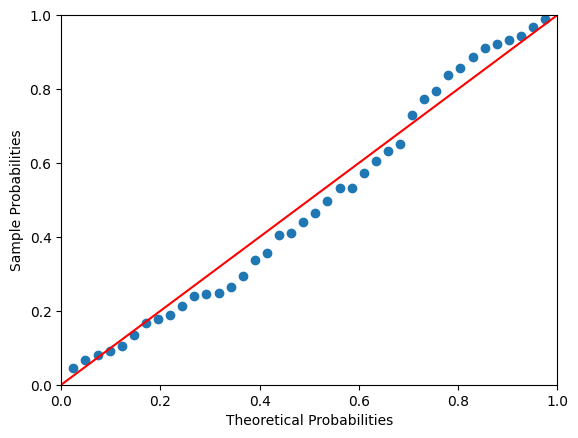

In [14]:
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(mba_salary_lm)
std_resid = influence.resid_studentized_internal
probplot = sm.ProbPlot(std_resid)
probplot.ppplot(line='45')
plt.show()

In [15]:
def get_standardized_values(vals):
    return(vals - vals.mean())/vals.std()

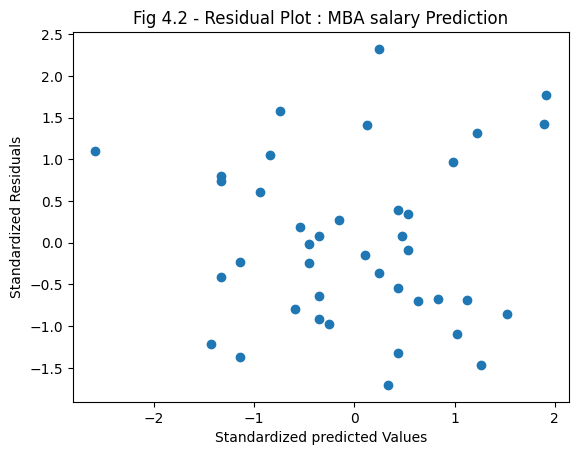

In [16]:
plt.scatter( get_standardized_values( mba_salary_lm.fittedvalues), get_standardized_values(mba_salary_resid))
plt.title( "Fig 4.2 - Residual Plot : MBA salary Prediction");
plt.xlabel("Standardized predicted Values")
plt.ylabel("Standardized Residuals");

### Outlier Analysis

### 1. Z-score

In [19]:
from scipy.stats import zscore

In [20]:
mba_salary_df['z_score_salary'] = zscore(mba_salary_df.Salary)
mba_salary_df[(mba_salary_df.z_score_salary>3.0)|(mba_salary_df.z_score_salary < -3.0)]

,S. No.,Percentage in Grade 10,Salary,z_score_salary


### 2. Cook's Distance 

In [22]:
import numpy as np

Text(0, 0.5, "Cook's Distance")

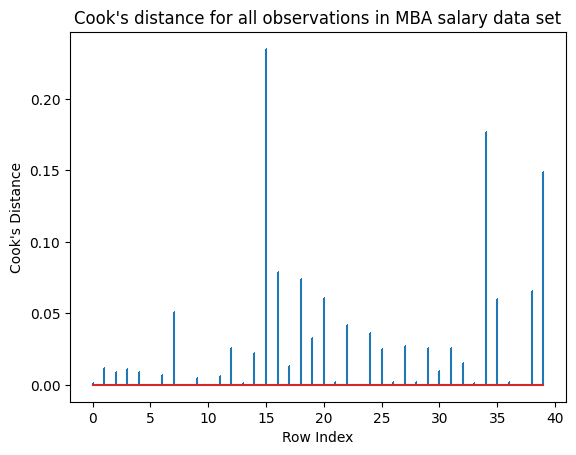

In [23]:
mba_influence = mba_salary_lm.get_influence()
(c,p) = mba_influence.cooks_distance

plt.stem(np.arange(len (train_X) ),
         np.round(c,3),
         markerfmt = ",");
plt.title ("Cook's distance for all observations in MBA salary data set")
plt.xlabel("Row Index")
plt.ylabel("Cook's Distance")

### 3. Leverage Values

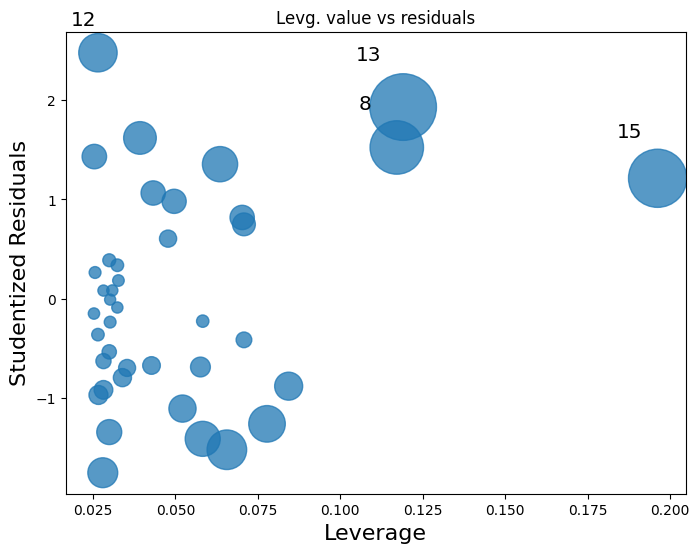

In [25]:
from statsmodels.graphics.regressionplots import influence_plot

fig, ax = plt.subplots(figsize = (8,6))
influence_plot(mba_salary_lm, ax = ax)
plt.title("Levg. value vs residuals")
plt.show();

### Predicting using the Validation set 

In [53]:
pred_Y = mba_salary_lm.predict(test_X)

In [49]:
from sklearn.metrics import r2_score, mean_squared_error

In [55]:
np.abs(r2_score(test_Y, pred_Y))

0.156645849742304

In [59]:
np.sqrt(mean_squared_error(test_Y, pred_Y))

73458.04348346895

In [61]:
test_Y.mean()

263360.0

In [63]:
rmse = np.sqrt(mean_squared_error(test_Y, pred_Y))
mean_y = np.mean(test_Y)

relative_rmse = (rmse / mean_y) * 100

print("RMSE:", rmse)
print("Relative RMSE (%):", relative_rmse)

RMSE: 73458.04348346895
Relative RMSE (%): 27.892634980053522


### Calculating Prediction Intervals

In [72]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#predict the y values
pred_Y = mba_salary_lm.predict(test_X)

#predict the low and high interval values for y
_, pred_Y_low, pred_Y_high = wls_prediction_std(mba_salary_lm,test_X, alpha = 0.1)

#store all the values in a dataframe 
pred_Y_df = pd.DataFrame({ 'grade_10_prece': test_X [ 'Percentage in Grade 10'],
                          'pred_Y': pred_Y,
                          'pred_Y_left': pred_Y_low,
                          'pred_Y_right': pred_Y_high})
pred_Y_df[0:10]

,grade_10_prece,pred_Y,pred_Y_left,pred_Y_right
6,70.0,279828.402452,158379.831862,401276.973042
36,68.0,272707.227686,151576.714839,393837.740534
37,52.0,215737.829560,92950.942211,338524.716909
28,58.0,237101.353858,115806.869437,358395.838278
43,74.5,295851.045675,173266.083158,418436.008191
49,60.8,247070.998530,126117.560802,368024.436257
5,55.0,226419.591709,104507.444206,348331.739212
33,78.0,308313.101515,184450.060303,432176.142727
20,63.0,254904.290772,134057.999077,375750.582466
42,74.4,295494.986937,172941.528507,418048.445366
